Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [66]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Rescaling , RandomZoom, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy


In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
dataset_file_path = '/content/gdrive/MyDrive/Melanoma_CNN_data'
data_dir_train = pathlib.Path(dataset_file_path + '/Train')
data_dir_test = pathlib.Path(dataset_file_path + '/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

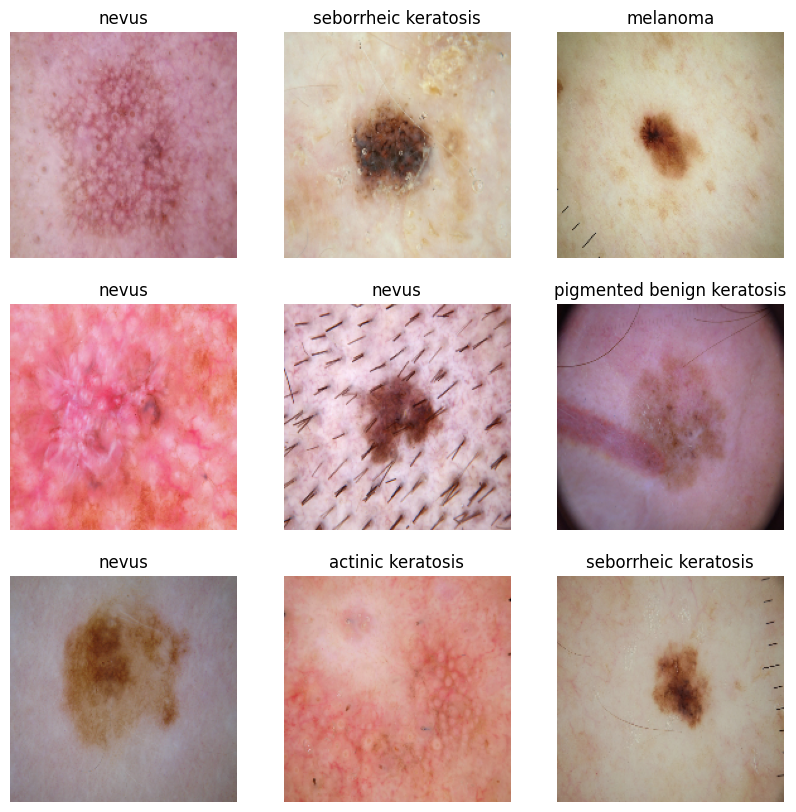

In [11]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 10))

# Take one batch from the dataset
for images, labels in train_ds.take(2):
    for i in range(9):  # Loop through first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i].numpy()])  # Convert label tensor to index
        plt.axis("off")

plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
pre_process_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
### Your code goes here

input_shape = (180, 180, 3)
lr = 1e-5
init = 'he_normal'  # He initialization for better convergence

model = Sequential([
    Rescaling(1./255, input_shape=input_shape),

    Conv2D(32, kernel_size=(3, 3), kernel_initializer=init, padding="same"),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Conv2D(32, kernel_size=(3, 3), kernel_initializer=init, padding="same"),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), kernel_initializer=init, padding="same"),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), kernel_initializer=init, padding="same"),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, kernel_initializer=init),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 15,964,769 (60.90 MB)

 Trainable params: 15,963,745 (60.90 MB)

 Non-trainable params: 1,024 (4.00 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4)  # Better generalization
loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0)  # Handles class imbalance

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        'accuracy'
       # ,tf.keras.metrics.Precision(name='precision'),
       # tf.keras.metrics.Recall(name='recall'),
       # tf.keras.metrics.AUC(name='auc')
    ]
)


In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 15,964,769 (60.90 MB)

 Trainable params: 15,963,745 (60.90 MB)

 Non-trainable params: 1,024 (4.00 KB)

### Train the model

In [18]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.1245 - loss: -22.9198 - val_accuracy: 0.1186 - val_loss: 60.1222
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1111 - loss: -303.8438 - val_accuracy: 0.1356 - val_loss: -58.0532
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.1197 - loss: -496.6443 - val_accuracy: 0.1356 - val_loss: -437.3314
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.1069 - loss: -692.0887 - val_accuracy: 0.1356 - val_loss: -403.1009
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1021 - loss: -760.0959 - val_accuracy: 0.1271 - val_loss: -385.7018
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.1050 - loss: -830.2147 - val_accuracy: 0.1441 - val_loss: -332.1853
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.0876 - loss: -967.7955 - val_accuracy: 0.1186 - val_loss: -306.9253
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.0739 - lo

### Visualizing training results

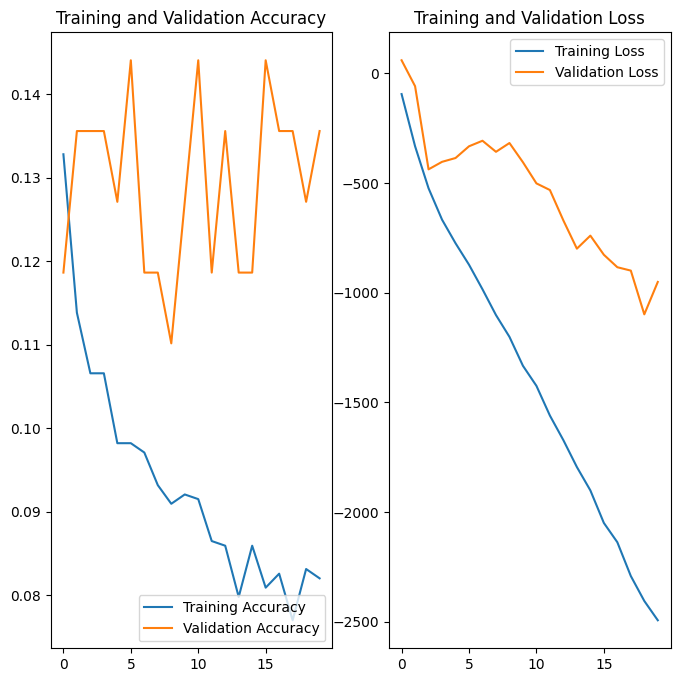

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [20]:
results = model.evaluate(train_ds, verbose=1)
print(results)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0785 - loss: -2588.6426
[-2531.946044921875, 0.0842633917927742]


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0938 - loss: -2667.3789
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1428 - loss: -986.6584
Accuracy:  0.0842633917927742
Validation Accuracy:  0.1355932205915451
Loss:  -2531.946044921875
Validation Loss -950.9389038085938


In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


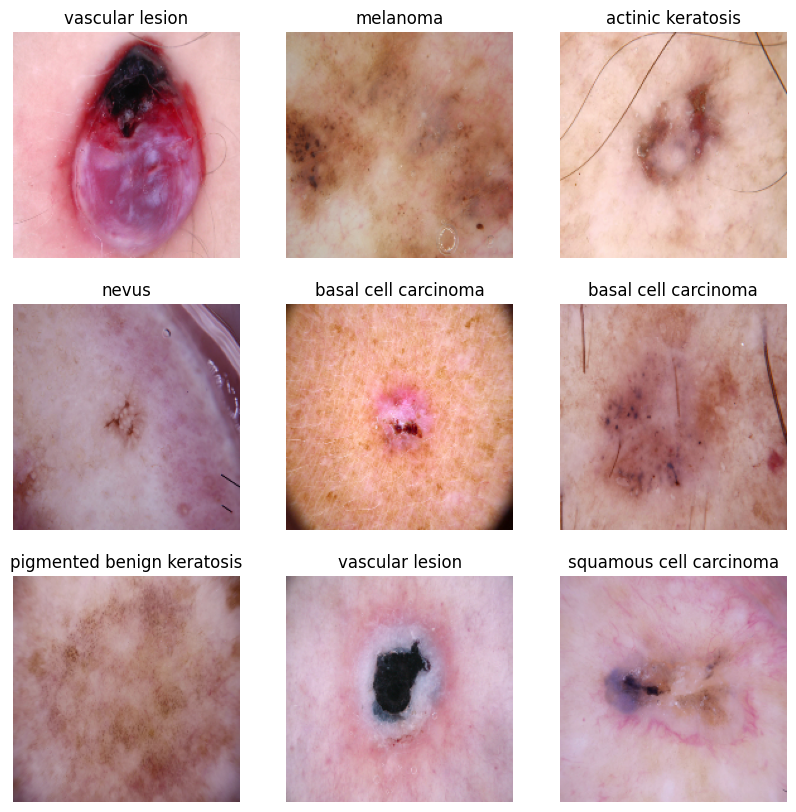

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 10))

# Take one batch from the dataset
for images, labels in train_ds.take(1):
    for i in range(9):  # Loop through first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i].numpy()])  # Convert label tensor to index
        plt.axis("off")

plt.show()

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      28,901,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [26]:
## Your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Training the model

In [28]:
print("train_batches = ", train_batches.batch_size)

train_batches =  64


In [29]:
print(train_batches)

In [30]:
print(valid_batches.batch_size)

64


### Visualizing the results

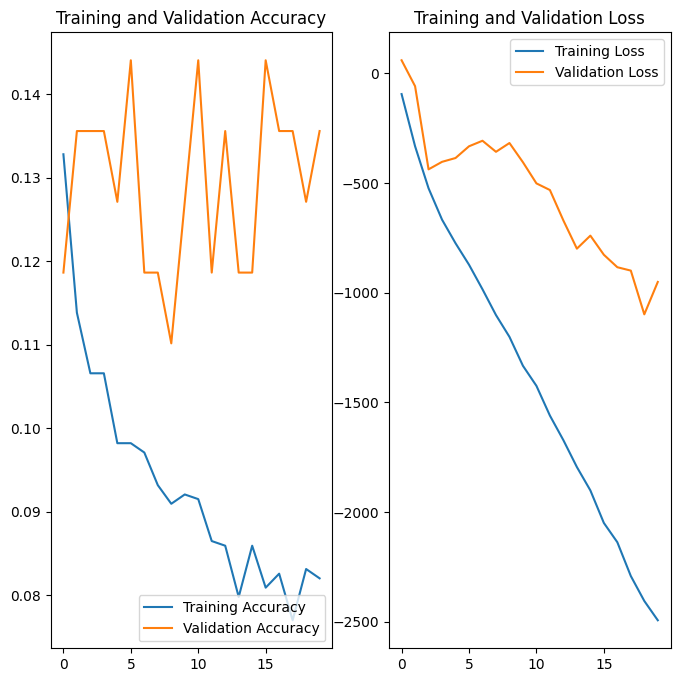

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

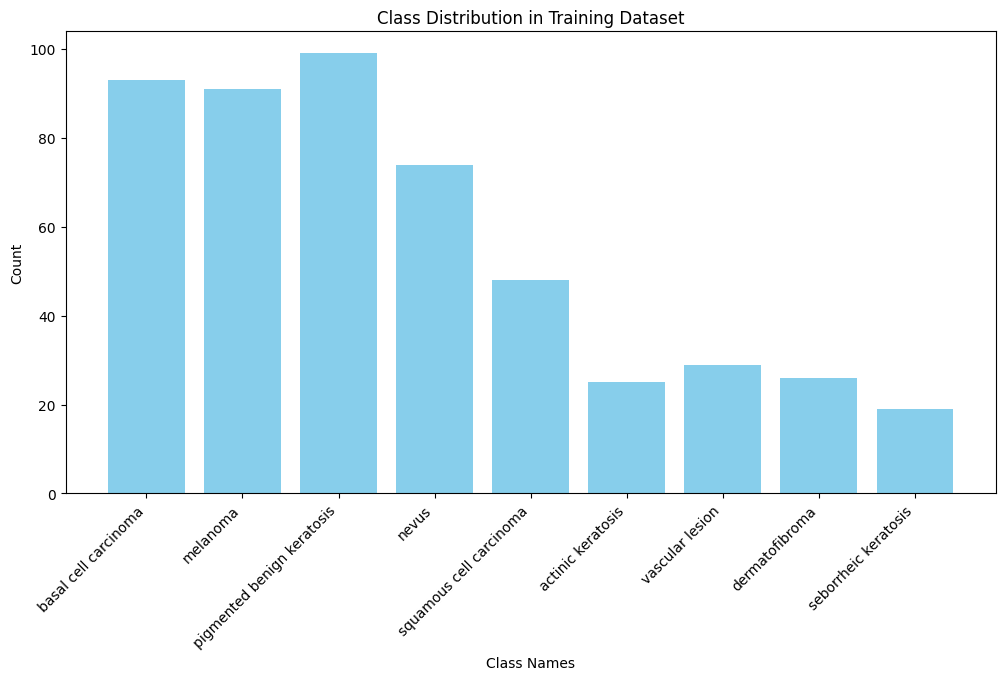

In [32]:
## Your code goes here.
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize dictionary to store class counts
class_counts = defaultdict(int)

# Loop through the dataset to count occurrences
for batch_images, batch_labels in train_ds:
    for idx in range(min(len(batch_labels), 9)):  # Avoid index out of range
        class_name = class_names[batch_labels[idx].numpy()]  # Convert tensor to index
        class_counts[class_name] += 1

# Set figure size for better visualization
plt.figure(figsize=(12, 6))

# Create bar chart for class distribution
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")

# Format x-axis labels
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Class Distribution in Training Dataset")

# Show plot
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma_CNN_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE60605A90>: 100%|██████████| 500/500 [00:24<00:00, 20.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EE49904CD0>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE0ED55210>: 100%|██████████| 500/500 [00:20<00:00, 24.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78EE6021F790>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EE499F8ED0>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78EE74261890>: 100%|██████████| 500/500 [00:18<00:00, 27.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78EE1A34C2D0>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE600EE250>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_CNN_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78EE0ED79A50>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0000234.jpg_c31d8ad6-5d1d-4781-8245-0ba6a61a7d7a.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0029041.jpg_4a59811b-ca4a-4478-a5a3-f5f21821281b.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0029460.jpg_eca77359-a9bf-4fc0-ba91-fcd62a01de9e.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0000058.jpg_6028e952-f5cc-4d4d-aa14-799d8c95c995.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0025953.jpg_9e81d78b-27e5-4712-a04f-d85abbd0f376.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0000344.jpg_c5bdf53c-157a-4150-8dd2-a8078eac2c3a.jpg',
 '/content/gdrive/MyDrive/Melanoma_CNN_data/Train/nevus/output/nevus_original_ISIC_0000358.jpg_1b94245d-f654-464a-965e-85f362fde2fd.jpg',
 '/content/gdrive/MyDrive/Melanoma

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [43]:
new_df['Label'].value_counts()

,count
Label,
nevus,500
vascular lesion,500
seborrheic keratosis,500
actinic keratosis,500
basal cell carcinoma,500
melanoma,500
pigmented benign keratosis,500
dermatofibroma,500
squamous cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
data_dir_train="/content/gdrive/MyDrive/Melanoma_CNN_data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to.
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here

# Define model
model = Sequential()

# Convolutional Block 1 (32 filters)
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())  # Placed before activation
model.add(tf.keras.layers.ReLU())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

# Convolutional Block 2 (64 filters)
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.35))

# Convolutional Block 3 (128 filters)
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

# Convolutional Block 4 (256 filters)
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(Dropout(0.5))

# Output Layer (Modify `num_classes` accordingly)
num_classes = 10  # Change based on dataset (e.g., 1 for binary, >1 for multi-class)
model.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))

# Print summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 45, 45, 128)         │              

 Total params: 8,518,698 (32.50 MB)

 Trainable params: 8,516,778 (32.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here

# Optimized Adam Optimizer
optimizer = Adam(
    learning_rate=0.001,  # Initial learning rate
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,  # Avoids division by zero
    amsgrad=True  # Improves training stability
)

# Compile Model with Optimized Settings
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=False),  # Use from_logits=True if no softmax activation
    optimizer=optimizer,
    metrics=['accuracy']
)

# Adaptive Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce LR when validation loss stops improving
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait for 3 epochs before reducing LR
    min_lr=1e-6,  # Minimum learning rate to prevent underflow
    verbose=1
)

# Add `lr_scheduler` to model training
callbacks = [lr_scheduler]


#### **Todo:**  Train your model

In [68]:
## Your code goes here, use 50 epochs.


# Set training parameters
epochs = 50
batch_size = 32  # Increased batch size for faster convergence

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # More stable than val_accuracy
    patience=3,  # Wait 3 epochs before reducing LR
    factor=0.5,  # Reduce LR by half
    min_lr=1e-5,  # Minimum LR to prevent underflow
    verbose=1,
    min_delta=0.001  # Avoid reducing LR for minor fluctuations
)

# Stop training if validation loss does not improve for 6 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Slightly higher patience for robustness
    restore_best_weights=True,  # Keeps best model weights
    verbose=1
)

# Save best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the model with optimized settings
history = model.fit(
    x=train_ds,
    epochs=epochs,
    batch_size=batch_size,  # Increased for better performance
    verbose=1,
    validation_data=val_ds,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]  # Added early stopping & checkpointing
)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.3173 - loss: 2.0207
Epoch 1: val_accuracy improved from -inf to 0.40386, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 343ms/step - accuracy: 0.3176 - loss: 2.0192 - val_accuracy: 0.4039 - val_loss: 1.9243 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.4627 - loss: 1.4760
Epoch 2: val_accuracy improved from 0.40386 to 0.46474, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 262ms/step - accuracy: 0.4628 - loss: 1.4759 - val_accuracy: 0.4647 - val_loss: 1.4795 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5253 - loss: 1.3320
Epoch 3: val_accuracy improved from 0.46474 to 0.52339, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 241ms/step - accuracy: 0.5253 - loss: 1.3318 - val_accuracy: 0.5234 - val_loss: 1.2944 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5437 - loss: 1.2390
Epoch 4: val_accuracy improved from 0.52339 to 0.55679, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.5438 - loss: 1.2388 - val_accuracy: 0.5568 - val_loss: 1.2266 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6092 - loss: 1.0612
Epoch 5: val_accuracy did not improve from 0.55679
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.6092 - loss: 1.0611 - val_accuracy: 0.4454 - val_loss: 1.6658 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6519 - loss: 0.9784
Epoch 6: val_accuracy did not improve from 0.55679
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step - accuracy: 0.6519 - loss: 0.9783 - val_accuracy: 0.4840 - val_loss: 1.3773 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6831 - loss: 0.8757
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_accuracy improved from 0.55679 to 0.56347, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.6832 - loss: 0.8755 - val_accuracy: 0.5635 - val_loss: 1.2340 - learning_rate: 0.0010
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7329 - loss: 0.7330
Epoch 8: val_accuracy improved from 0.56347 to 0.66815, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 261ms/step - accuracy: 0.7330 - loss: 0.7328 - val_accuracy: 0.6682 - val_loss: 0.9317 - learning_rate: 5.0000e-04
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7665 - loss: 0.6364
Epoch 9: val_accuracy improved from 0.66815 to 0.72235, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 255ms/step - accuracy: 0.7665 - loss: 0.6363 - val_accuracy: 0.7223 - val_loss: 0.7683 - learning_rate: 5.0000e-04
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7803 - loss: 0.6140
Epoch 10: val_accuracy did not improve from 0.72235
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step - accuracy: 0.7803 - loss: 0.6138 - val_accuracy: 0.6852 - val_loss: 0.8410 - learning_rate: 5.0000e-04
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8078 - loss: 0.5440
Epoch 11: val_accuracy improved from 0.72235 to 0.73348, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 243ms/step - accuracy: 0.8078 - loss: 0.5439 - val_accuracy: 0.7335 - val_loss: 0.7558 - learning_rate: 5.0000e-04
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8166 - loss: 0.5144
Epoch 12: val_accuracy improved from 0.73348 to 0.80104, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.8167 - loss: 0.5143 - val_accuracy: 0.8010 - val_loss: 0.5834 - learning_rate: 5.0000e-04
Epoch 13/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8123 - loss: 0.5085
Epoch 13: val_accuracy did not improve from 0.80104
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.8124 - loss: 0.5083 - val_accuracy: 0.7862 - val_loss: 0.6193 - learning_rate: 5.0000e-04
Epoch 14/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8329 - loss: 0.4576
Epoch 14: val_accuracy did not improve from 0.80104
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 243ms/step - accuracy: 0.8330 - loss: 0.4575 - val_accuracy: 0.7743 - val_loss: 0.6404 - learning_rate: 5.0000e-04
Epoch 15/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8405 - loss: 0.4387
Epoch 15: val_accuracy improved from 0.80104 to 0.84261, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 263ms/step - accuracy: 0.8405 - loss: 0.4386 - val_accuracy: 0.8426 - val_loss: 0.4653 - learning_rate: 5.0000e-04
Epoch 16/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8376 - loss: 0.4367
Epoch 16: val_accuracy did not improve from 0.84261
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.8377 - loss: 0.4366 - val_accuracy: 0.7899 - val_loss: 0.5745 - learning_rate: 5.0000e-04
Epoch 17/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8590 - loss: 0.3979
Epoch 17: val_accuracy did not improve from 0.84261
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.8590 - loss: 0.3978 - val_accuracy: 0.8070 - val_loss: 0.5517 - learning_rate: 5.0000e-04
Epoch 18/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8718 - loss: 0.3641
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: val_accuracy did not improve from 0.84261
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 246ms/step - accuracy:

169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 243ms/step - accuracy: 0.8773 - loss: 0.3389 - val_accuracy: 0.8530 - val_loss: 0.4503 - learning_rate: 2.5000e-04
Epoch 20/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8940 - loss: 0.2963
Epoch 20: val_accuracy did not improve from 0.85301
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step - accuracy: 0.8940 - loss: 0.2962 - val_accuracy: 0.8411 - val_loss: 0.4776 - learning_rate: 2.5000e-04
Epoch 21/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8955 - loss: 0.2961
Epoch 21: val_accuracy improved from 0.85301 to 0.86637, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.8955 - loss: 0.2960 - val_accuracy: 0.8664 - val_loss: 0.4195 - learning_rate: 2.5000e-04
Epoch 22/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8931 - loss: 0.2912
Epoch 22: val_accuracy improved from 0.86637 to 0.86934, saving model to best_model.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 256ms/step - accuracy: 0.8931 - loss: 0.2911 - val_accuracy: 0.8693 - val_loss: 0.3861 - learning_rate: 2.5000e-04
Epoch 23/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9109 - loss: 0.2617
Epoch 23: val_accuracy did not improve from 0.86934
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - accuracy: 0.9109 - loss: 0.2617 - val_accuracy: 0.8486 - val_loss: 0.4494 - learning_rate: 2.5000e-04
Epoch 24/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9083 - loss: 0.2578
Epoch 24: val_accuracy did not improve from 0.86934
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - accuracy: 0.9083 - loss: 0.2579 - val_accuracy: 0.8627 - val_loss: 0.4026 - learning_rate: 2.5000e-04
Epoch 25/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9091 - loss: 0.2571
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 25: val_accuracy did not improve from 0.86934
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy:

#### **Todo:**  Visualize the model results

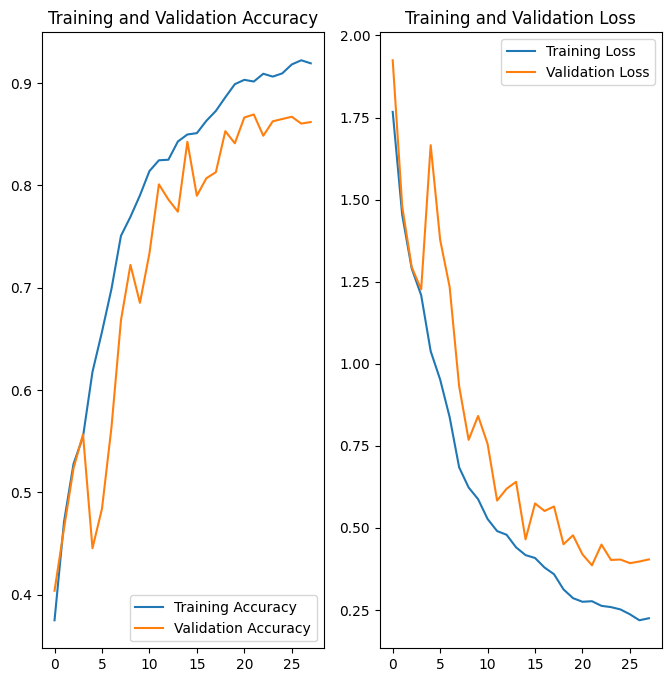

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 28

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# ***ANALYSIS BELOW:***

**Left Plot**: *Training and Validation Accuracy*
The training accuracy (blue) increases steadily and reaches above 90%.

The validation accuracy (orange) follows a similar trend but has fluctuations, stabilizing around 85%.

The gap between training and validation accuracy suggests some overfitting, but it’s not extreme.

**Right Plot**: *Training and Validation Loss*
The training loss (blue) consistently decreases, which is expected.

The validation loss (orange) also decreases but fluctuates more.

Around epoch 15-20, validation loss stops decreasing significantly, suggesting diminishing returns in training.

**Good Performance**: The model learns well, and validation accuracy is close to training accuracy.

**Overfitting Risk minimized**: The gap between training and validation accuracy suggests overfitting has been minimized.

**Good Learning Rate**: No sudden jumps in loss, meaning the optimizer is working well.

**Early Stopping Helped**: The validation loss is fluctuating, which might indicate a need for early stopping. Hence implemented this in the above solution.


